In [1]:
import pandas as pd
import torch
import numpy as np
from matplotlib import pyplot as plt

In [2]:
data = pd.read_csv('cirrhosis.csv').dropna()
data

,index,duration,status,drug,age,sex,ascites,hepatomology,spiders,edema,bilirubin,cholesterol,albumin,copper,phosphatase,SGOT,triglicerides,platelets,prothrombin,stage
0,1,400,2,1,21464,1,1,1,1,1.0,14.5,261.0,2.60,156.0,1718.0,137.95,172.0,190.0,12.2,4
1,2,4500,0,1,20617,1,0,1,1,0.0,1.1,302.0,4.14,54.0,7394.8,113.52,88.0,221.0,10.6,3
2,3,1012,2,1,25594,0,0,0,0,0.5,1.4,176.0,3.48,210.0,516.0,96.10,55.0,151.0,12.0,4
3,4,1925,2,1,19994,1,0,1,1,0.5,1.8,244.0,2.54,64.0,6121.8,60.63,92.0,183.0,10.3,4
4,5,1504,1,2,13918,1,0,1,1,0.0,3.4,279.0,3.53,143.0,671.0,113.15,72.0,136.0,10.9,3
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
307,308,1153,0,1,22347,1,0,1,0,0.0,0.4,246.0,3.58,24.0,797.0,91.00,113.0,288.0,10.4,2
308,309,994,0,2,21294,1,0,0,0,0.0,0.4,260.0,2.75,41.0,1166.0,70.00,82.0,231.0,10.8,2
309,310,939,0,1,22767,1,0,0,0,0.0,1.7,434.0,3.35,39.0,1713.0,171.00,100.0,234.0,10.2,2
310,311,839,0,1,13879,1,0,0,0,0.0,2.0,247.0,3.16,69.0,1050.0,117.00,88.0,335.0,10.5,2


In [3]:
data = data.sort_values('duration', axis=0).reset_index()
durs = np.array(data['duration'].unique())
durs.shape

(267,)

In [4]:
data.query('duration < 41').shape[0]

0

In [5]:
counts = np.zeros_like(durs)
for i,dur in enumerate(durs):
    counts[i] += (312 - data.query('duration < '+ str(dur)).shape[0])
counts

array([312, 311, 310, 309, 308, 307, 306, 305, 304, 303, 302, 301, 300,
       299, 298, 297, 296, 295, 294, 293, 292, 291, 290, 289, 288, 287,
       286, 285, 284, 283, 282, 281, 280, 279, 278, 277, 276, 275, 274,
       273, 272, 271, 270, 269, 268, 267, 266, 265, 264, 263, 262, 261,
       260, 259, 258, 257, 256, 255, 254, 253, 252, 251, 250, 249, 248,
       247, 246, 245, 244, 243, 241, 240, 238, 237, 236, 235, 234, 233,
       232, 231, 230, 229, 228, 227, 226, 225, 224, 223, 222, 221, 219,
       218, 217, 216, 215, 214, 213, 212, 211, 209, 208, 207, 206, 205,
       204, 203, 202, 201, 200, 199, 198, 197, 196, 195, 194, 192, 191,
       190, 189, 188, 187, 185, 184, 183, 182, 181, 180, 179, 178, 177,
       176, 175, 174, 173, 172, 171, 170, 169, 168, 166, 165, 164, 163,
       162, 161, 160, 159, 158, 157, 156, 155, 154, 153, 152, 151, 150,
       149, 148, 147, 146, 144, 143, 142, 141, 140, 139, 138, 137, 136,
       135, 134, 133, 132, 131, 130, 129, 128, 127, 126, 125, 12

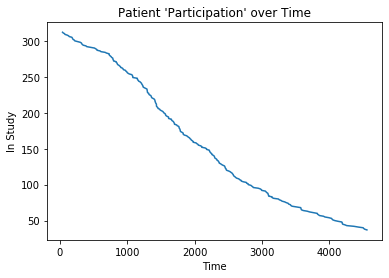

In [6]:
plt.plot(durs,counts)
plt.title("Patient 'Participation' over Time")
plt.ylabel("In Study")
plt.xlabel("Time")
plt.show()

In [7]:
rate = 1
rates = [1]
at_risk = data.shape[0]
alive = at_risk
for i,row in data.iterrows():
    alive -= 1
    if row['status'] == 2:
        rate *= (alive / at_risk)
    at_risk -= 1
    rates.append(rate)

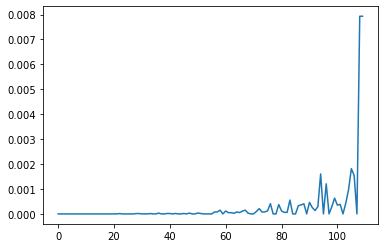

In [8]:
h = -np.diff(rates)
plt.plot(np.diff(h[h!=0]))

In [9]:
x = torch.Tensor(data.drop(['duration', 'status', 'index'], axis=1).values).float()
for i in range(x.T.shape[0]):
    x.T[i] -= torch.min(x.T[i])
    x.T[i] /= torch.max(x.T[i])
    
durations = torch.Tensor(data['duration'].values).float()
failed = torch.Tensor((data['status'] == 2).values).bool()
x[0]

tensor([0.9003, 0.0000, 0.7593, 1.0000, 1.0000, 0.0000, 0.0000, 1.0000, 0.6354,
        0.0332, 0.0574, 0.3699, 0.0306, 0.7219, 0.3469, 0.0000, 0.4815, 1.0000])

In [10]:
def CoxLoss(p, durations, failed):
    loss = 0
    for t,i in zip(durations[failed], np.arange(p.shape[0])[failed]):
        at_risk = durations >= t
        loss += torch.sum(torch.log(torch.sum(torch.exp(p[at_risk]), dim=0)) - p[i], dim=0)
    
    return loss

In [11]:
durations.shape

torch.Size([276])

In [ ]:
class Layer(torch.nn.Module):
    def __init__(self, size_in, size_out, activation):
        super(Layer, self).__init__()
        self.weights = torch.nn.Parameter(
            torch.randn(size_in, size_out, requires_grad=True)
        )
        self.bias = torch.nn.Parameter(
            torch.randn(1, size_out, requires_grad=True)
        )  
        self.activation = activation
        
    def forward(self, z_in):
        return self.activation(z_in @ self.weights + self.bias)

In [28]:
model = Layer(x.shape[1], 1, lambda z: z)

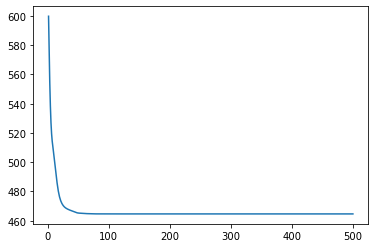

In [29]:
iterations=500
losses = [np.inf]
optim = torch.optim.Adam(model.parameters(), lr=1e-1, )
batch_size = x.shape[0]
for i in range(iterations):
    idx = np.random.permutation(x.shape[0])[:batch_size]
    print('{:>5} | {:>12.3}\r'.format(i, losses[-1]), end='')
    p = model(x[idx])
    loss = CoxLoss(p, durations[idx], failed[idx])
    loss.backward()
    losses.append(CoxLoss(model(x), durations, failed).detach())
    optim.step()
    optim.zero_grad()
plt.plot(losses)

In [33]:
model(x)[:]

tensor([[ -5.3919],
        [ -6.5008],
        [ -8.1085],
        [ -7.3670],
        [ -9.4983],
        [ -5.2810],
        [ -7.0870],
        [ -7.2104],
        [ -9.4497],
        [ -7.9742],
        [-11.2441],
        [ -6.9086],
        [ -7.3706],
        [ -5.4127],
        [ -9.2847],
        [ -9.3316],
        [ -8.9797],
        [ -7.0714],
        [ -8.4564],
        [ -8.1583],
        [ -6.3799],
        [ -8.5493],
        [-10.8475],
        [-10.1329],
        [ -6.9064],
        [ -8.8599],
        [ -9.9575],
        [ -8.9412],
        [ -8.5276],
        [ -9.5728],
        [ -9.6438],
        [ -9.4149],
        [-11.4358],
        [ -8.8952],
        [ -8.9432],
        [ -9.4938],
        [-10.3208],
        [-11.7300],
        [ -9.9179],
        [ -8.4243],
        [-10.5501],
        [-10.5591],
        [-11.7673],
        [ -9.6273],
        [ -8.4457],
        [ -6.9585],
        [-11.3685],
        [ -8.1121],
        [-10.2775],
        [ -9.7539],


In [1]:
def ConcordanceIndex(T,R):
    t = T < T.T
    r = R > R.T
        
    return np.sum(t*r) / np.sum(t)